In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
import pickle
with open('../DATA/super_res/super_res_array.pickle','rb') as f:
    img_array = pickle.load(f)


In [3]:
from sklearn.model_selection import train_test_split 

all_images = np.array(img_array)

#Split test and train data. all_images will be our output images
train_x, test_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [4]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 20):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
    # scale back to original size
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)
    low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
    return low_res_image

In [5]:
train_x_px = []
for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)
    
train_x_px = np.array(train_x_px)   #Distorted images
# get low resolution images for the validation set
test_x_px = []
for i in range(test_x.shape[0]):
    temp = pixalate_image(test_x[i,:,:,:])
    test_x_px.append(temp)
    
test_x_px = np.array(test_x_px)     #Distorted images

In [6]:
train_x_px.shape

(10586, 160, 160, 3)

In [7]:
from AE_RESNET.resnetAE import ResNetAE

In [8]:
resnet50AE = ResNetAE(input_shape=(160,160,3), output_channels=3, resnet_decoder=True,
                      bottleneck_layers=[3,4,6,3],bottleneck_strides=[1,2,2,2], 
                      bottleneck_num_layer=3)
resnet50AE.summary()

Model: "ResNetAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 ResNet_encoder (Functional)  (None, 5, 5, 2048)       23587712  
                                                                 
 ResNet_decoder (Functional)  (None, 160, 160, 3)      28838031  
                                                                 
Total params: 52,425,743
Trainable params: 52,319,625
Non-trainable params: 106,118
_________________________________________________________________


In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.0003)
resnet50AE.compile(optimizer=optimizer, loss="mse")

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = resnet50AE.fit(
    train_x_px,
    train_x,
    epochs=40,
    batch_size=16, 
    shuffle=True,
    validation_split=0.1, 
    callbacks=[early_stopping]
    )



Epoch 1/40
596/596 [==============================] - 173s 272ms/step - loss: 0.0307 - val_loss: 0.0229
Epoch 2/40
596/596 [==============================] - 160s 268ms/step - loss: 0.0163 - val_loss: 0.0134
Epoch 3/40
596/596 [==============================] - 160s 268ms/step - loss: 0.0114 - val_loss: 0.0125
Epoch 4/40
596/596 [==============================] - 161s 270ms/step - loss: 0.0088 - val_loss: 0.0110
Epoch 5/40
596/596 [==============================] - 160s 268ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 6/40
596/596 [==============================] - 160s 268ms/step - loss: 0.0063 - val_loss: 0.0075
Epoch 7/40
596/596 [==============================] - 160s 268ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 8/40
596/596 [==============================] - 160s 268ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 9/40
596/596 [==============================] - 160s 268ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 10/40
596/596 [==============================] - 160s 268m

In [22]:
resnet50AE.save('final_models/resnet50AE_lr0003.keras')

83/83 [==============================] - 16s 157ms/step


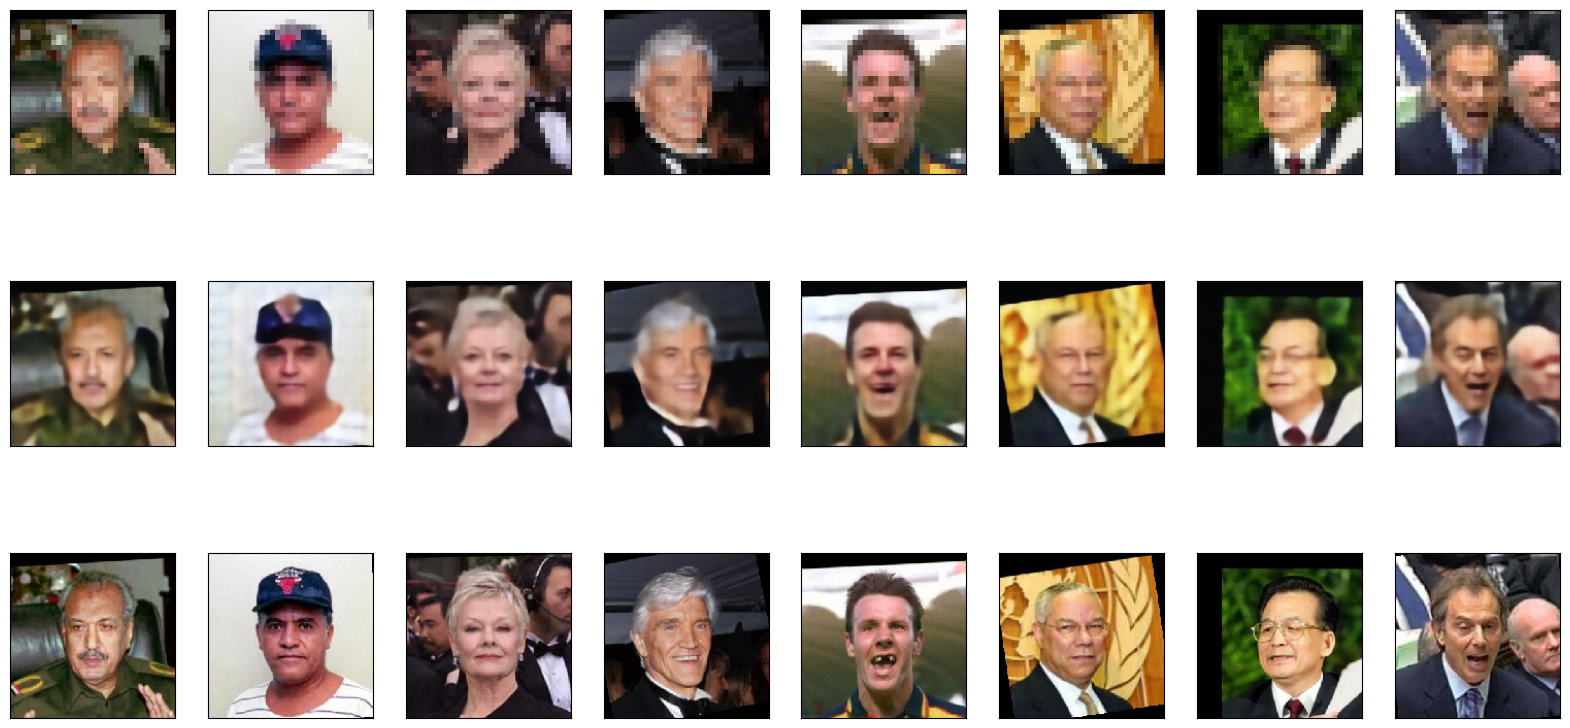

In [13]:
predictions = resnet50AE.predict(test_x_px)
n = 8
plt.figure(figsize= (20,10))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(test_x_px[i+3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(predictions[i+3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(test_x[i+3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
test_x_pru = np.squeeze(test_x)
predictions_pru = np.squeeze(predictions)
resnet50AE.evaluate(test_x_pru, predictions_pru, channel_axis=-1)

SSIM: 0.9538055062294006
PSNR: 23.756794999607646


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lr(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

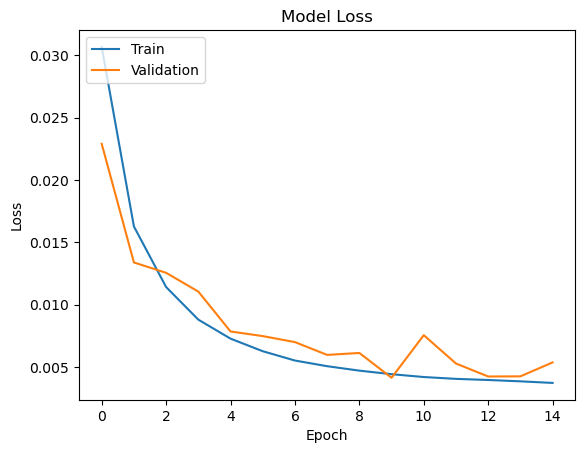

In [17]:
plot_lr(history)